In [1]:
import gpxpy
import pandas as pd

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen

In [2]:
def readData(url):
    with open(url) as fh:
        gpx_file = gpxpy.parse(fh)

    segment = gpx_file.tracks[0].segments[0]
    coords = pd.DataFrame([{'lat': p.latitude, 
                            'lon': p.longitude, 
                            'ele': p.elevation,
                            'time': p.time} for p in segment.points])
    coords.set_index('time', drop=True, inplace=True)

    start_time, end_time = segment.get_time_bounds()
    duration = end_time - start_time

    segment.points[0].speed = 0.0
    segment.points[-1].speed = 0.0
    gpx_file.add_missing_speeds()

    coords['speed'] = [p.speed for p in segment.points]
    coords['speed'] *= 3.6

    coords.index = (coords.index - coords.index[0]).total_seconds()
    
    return coords

In [3]:
coords = readData('activity_12412886281.gpx')
coords.index = np.arange(0,len(coords),1)

In [4]:
def plotHeatmap(coords):
    
    campo_l_caxias_inf_dir = np.asarray([-27.061048, -51.193657])

    posxy = pd.DataFrame()
    posxy['x'] = coords['lat'] - campo_l_caxias_inf_dir[0]
    posxy['y'] = coords['lon'] - campo_l_caxias_inf_dir[1]

    posxy['x'] = posxy['x']*111139
    posxy['y'] = posxy['y']*111139

    # setup pitch
    pitch = Pitch(pitch_type='custom', line_zorder=2,
                pitch_color='grass', line_color='white',
                stripe_color='#c2d59d',
                pitch_length=100,pitch_width=65)
    # draw
    fig, ax = pitch.draw(figsize=(6.6, 4.125))
    # fig.set_facecolor('#22312b')
    bin_statistic = pitch.bin_statistic(posxy['y'].values, posxy['x'].values, statistic='count', bins=(50, 50))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', shading='flat')
    fig.show()

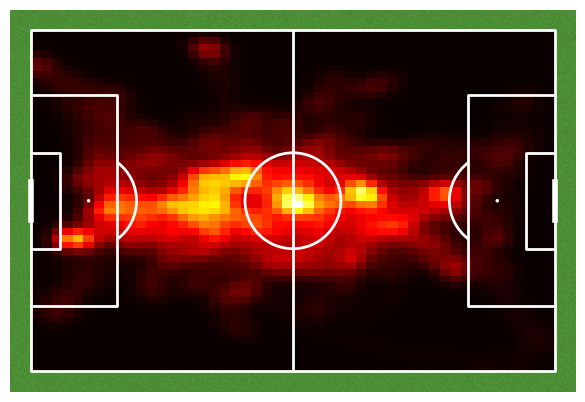

In [5]:
plotHeatmap(coords)

In [6]:
def plotSpeeds(df_speeds, threshold):    
    
    y = np.asarray(df_speeds['speed'])
    x = np.asarray(df_speeds.index)

    mascara = y > threshold

    plt.plot(x, y, linestyle='-', color='b')
    plt.plot(np.where(mascara)[0], y[mascara], 'ro')  # Marca os pontos acima de 6 com marcadores vermelhos
    plt.axhline(y=threshold, color='black', linestyle='--')

    plt.xlabel('Segundos')
    plt.ylabel('Velocidade')
    plt.grid(True)
    plt.show()

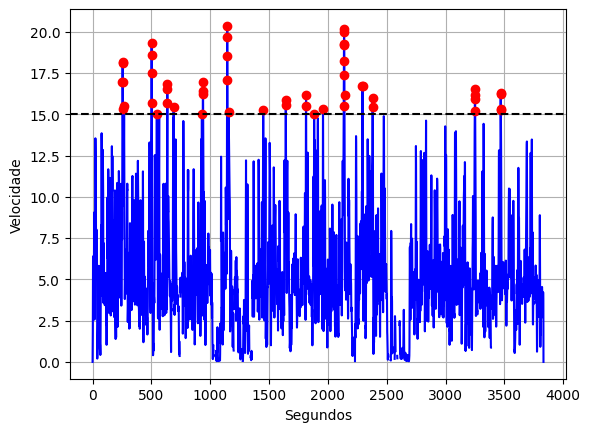

In [7]:
plotSpeeds(coords,15)

In [8]:
campo_l_caxias_inf_dir = np.asarray([-27.061048, -51.193657])

posxy = pd.DataFrame()
posxy['x'] = coords['lat'] - campo_l_caxias_inf_dir[0]
posxy['y'] = coords['lon'] - campo_l_caxias_inf_dir[1]

posxy['x'] = posxy['x']*111139
posxy['y'] = posxy['y']*111139

coords['x'] = np.asarray(posxy['x'])
coords['y'] = np.asarray(posxy['y'])

In [9]:
def evaluateSprints(coords):
        
    distances = np.zeros(len(coords.index))
    for i in range(len(coords.index)):
        distances[i] = np.sqrt((np.asarray(coords['x'])[i] - np.asarray(coords['x'])[i-1])**2 + (np.asarray(coords['y'])[i] - np.asarray(coords['y'])[i-1])**2)
    
    indices = distances > 10
    distances[indices] = 0

    sprints = []
    starts = []
    ends = []
    for i in range(len(distances)):
        window = 10

        t_start = i
        t_end = i + window

        sprints.append(np.sum(distances[t_start:t_end]))
        starts.append(t_start)
        ends.append(t_end)

    all_sprints = pd.DataFrame()
    all_sprints['distance_sum'] = np.asarray(sprints)
    all_sprints['t_start'] = np.asarray(starts)
    all_sprints['t_end'] = np.asarray(ends)

    sprints = all_sprints.groupby(all_sprints.index // 15).apply(lambda x: x.loc[x['distance_sum'].idxmax()])
    sprints.reset_index(drop=True, inplace=True)

    sprints_sorted = sprints.sort_values(by='distance_sum', ascending=False)

    return sprints_sorted

In [10]:
sprints = evaluateSprints(coords)

In [13]:
sprints['mean_speed'] = np.asarray(sprints['distance_sum'])/(np.asarray(sprints['t_end']) - np.asarray(sprints['t_start']))

In [14]:
sprints.head()

,distance_sum,t_start,t_end,mean_speed
142,52.703458,2133.0,2143.0,5.270346
33,45.638735,496.0,506.0,4.563873
16,45.159981,253.0,263.0,4.515998
17,42.649780,255.0,265.0,4.264978
76,42.584822,1142.0,1152.0,4.258482


In [11]:
def plotSprint(t_start):

    y = np.array(coords['x'])[t_start:t_start+10]
    x = np.array(coords['y'])[t_start:t_start+10]

    pitch = Pitch(pitch_type='custom', line_zorder=2,
                pitch_color='grass', line_color='white',
                stripe_color='#c2d59d',
                pitch_length=100,pitch_width=65)
    
    fig, ax = pitch.draw(figsize=(6.6, 4.125))
    pitch.plot(x, y, ax=ax, linewidth=4, color = 'lime')
    pitch.scatter(x[0], y[0], color='blue', label='Início', zorder=5, s=80, ax=ax)
    pitch.scatter(x[-1], y[-1], color='red', label='Fim', zorder=5, s=80, ax=ax)
    ax.legend()

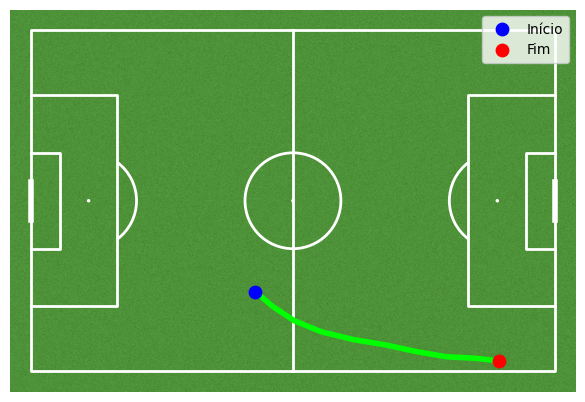

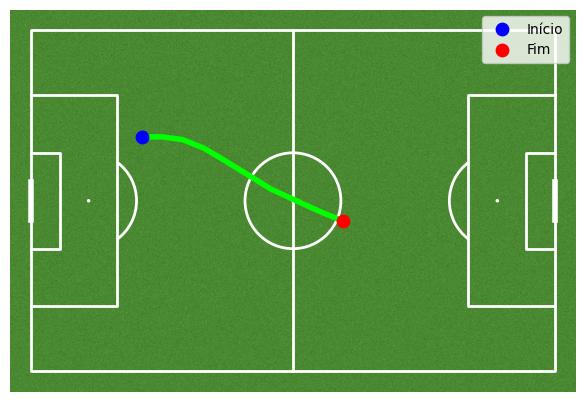

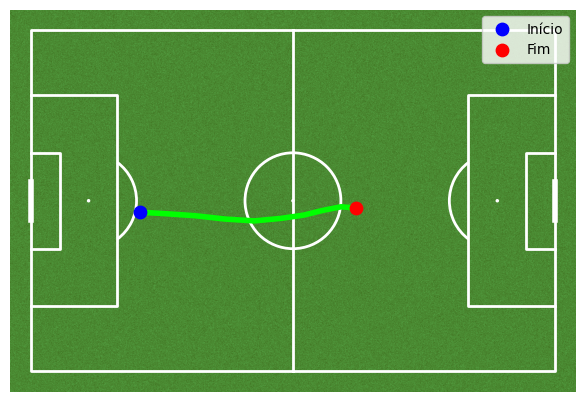

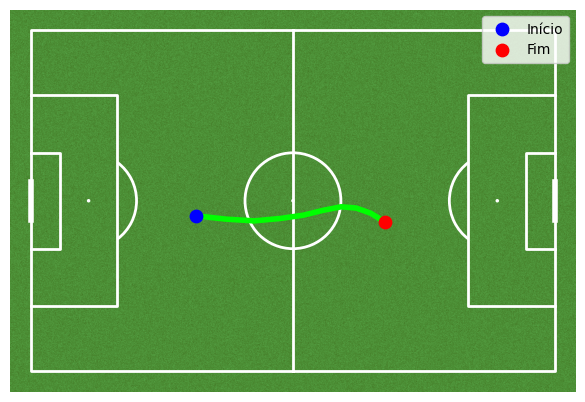

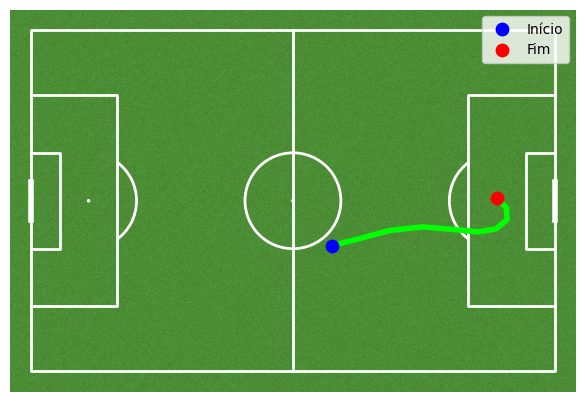

In [12]:
top_5_sprints = np.array(sprints['t_start'])[0:5]
for sprint in top_5_sprints:
    plotSprint(int(sprint))
    # print(sprint)